<a href="https://colab.research.google.com/github/JanMarcelKezmann/Residual-Network-Architectures/blob/master/Residual_Network_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf

from IPython.display import SVG
from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow.keras.backend as K
K.set_image_data_format("channels_last")
K.set_learning_phase(1)

from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Add, Dense, Flatten, Input, Conv2D, Activation, BatchNormalization, AveragePooling2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Create The Core Building Blocks

## Identity Block

In [0]:
def identity_block(X, f, filters, stage, block):
    conv_base_name = "conv" + str(stage) + block + "_branch"
    bn_base_name = "bn" + str(stage) + block + "_branch"

    # Filters
    F1, F2, F3 = filters

    # Save the Input X as Shortcut for later addition
    X_shortcut = X

    # Main Path
    # First Component of Main Path
    X = BatchNormalization(axis=3, name=bn_base_name + "2a")(X)
    X = Activation("relu")(X)
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding="valid", kernel_initializer=glorot_uniform(seed=0), name=conv_base_name + "2a")(X)

    # Second Component of Main Path
    X = BatchNormalization(axis=3, name=bn_base_name + "2b")(X)
    X = Activation("relu")(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0), name=conv_base_name + "2b")(X)

    # third Component of Main Path
    X = BatchNormalization(axis=3, name=bn_base_name + "2c")(X)
    X = Activation("relu")(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding="valid", kernel_initializer=glorot_uniform(seed=0), name=conv_base_name + "2c")(X)

    # Final Stage
    # Add Shortcut Path and Main Path
    X = Add()([X_shortcut, X])
    X = Activation("relu")(X) # is Activation neccessary

    return X

## Convolutional Block

In [0]:
def convolutional_block(X, f, filters, stage, block, strides=2):
    conv_base_name = "conv" + str(stage) + block + "_branch"
    bn_base_name = "bn" + str(stage) + block + "_branch"

    # Filters
    F1, F2, F3 = filters

    # Save the input X as Shortcut for later addition
    X_shortcut = X

    # Main Path
    # First Component of Main Path
    X = BatchNormalization(axis=3, name=bn_base_name + "2a")(X)
    X = Activation("relu")(X)
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(strides, strides), padding="valid", kernel_initializer=glorot_uniform(seed=0), name=conv_base_name + "2a")(X)

    # Second Component of Main Path
    X = BatchNormalization(axis=3, name=bn_base_name + "2b")(X)
    X = Activation("relu")(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0), name=conv_base_name + "2b")(X)

    # Third Component of Main Path
    X = BatchNormalization(axis=3, name=bn_base_name + "2c")(X)
    X = Activation("relu")(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding="valid", kernel_initializer=glorot_uniform(seed=0), name=conv_base_name + "2c")(X)

    # Shortcut Path
    X_shortcut = BatchNormalization(axis=3, name=bn_base_name + "1")(X_shortcut)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(strides, strides), padding="valid", kernel_initializer=glorot_uniform(seed=0), name=conv_base_name + "1")(X_shortcut)

    # Final Stage
    # Add Shortcut Path and Main Path
    X = Add()([X_shortcut, X])
    X = Activation("relu")(X)

    return X

In [0]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f=3, filters=[2, 4, 6], stage=1, block="a")
    sess.run(tf.global_variables_initializer())

    out = sess.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][0][0][0]))
    print(np.size(out))

out = [1.7617835 0.        0.        0.        1.6413738 0.       ]
288


# Create ResNetV2-164 Model

In [0]:
def ResNetV2_164(input_shape=(32, 32, 3), classes=100):
    # Define Tensor with shape input_shape
    X_input = Input(input_shape)
    print(X_input.shape)

    # ZeroPadding
    X = ZeroPadding2D((3, 3))(X_input)
    print(X.shape)

    # First Stage
    X = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), name="conv1", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    print(X.shape)

    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    print(X.shape)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block="a", strides=1)
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block="b")
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block="c")
    print(X.shape)

    # Stage 3
    X = convolutional_block(X, f=4, filters=[128, 128, 512], stage=3, block="a", strides=2)
    X = identity_block(X, f=4, filters=[128, 128, 512], stage=3, block="b")
    X = identity_block(X, f=4, filters=[128, 128, 512], stage=3, block="c")
    X = identity_block(X, f=4, filters=[128, 128, 512], stage=3, block="d")
    X = identity_block(X, f=4, filters=[128, 128, 512], stage=3, block="e")
    X = identity_block(X, f=4, filters=[128, 128, 512], stage=3, block="f")
    X = identity_block(X, f=4, filters=[128, 128, 512], stage=3, block="g")
    X = identity_block(X, f=4, filters=[128, 128, 512], stage=3, block="h")
    print(X.shape)

    # Stage 4
    X = convolutional_block(X, f=6, filters=[256, 256, 1024], stage=4, block="a", strides=2)
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="b")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="c")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="d")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="e")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="f")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="g")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="h")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="i")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="j")

    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="k")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="l")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="m")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="n")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="o")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="p")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="q")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="r")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="s")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="t")

    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="u")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="v")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="w")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="x")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="y")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="z")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="aa")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="ab")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="ac")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="ad")

    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="ae")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="af")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="ag")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="ah")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="ai")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="aj")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="ak")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="al")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="am")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="an")
    print(X.shape)

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block="a", strides=3)
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block="b")
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block="c")
    print(X.shape)

    # Final Stage
    #   X = AveragePooling2D((2, 2))(X)
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", name="fc" + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)
    print(X.shape)

    # Create Model
    model = Model(inputs=X_input, outputs=X, name="ResNetV2-164")

    return model

In [0]:
def random_mini_batches(X, y, mini_batch_size=32, seed=0):
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)

    # Step 1: shuffle (X, y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_y = X[permutation, :]

    # Step 2: partition (shuffled_X, shuffled_y)
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
    mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size, :, :, :]
    mini_batch_y = shuffled_y[k * mini_batch_size:(k + 1) * mini_batch_size, :]
    mini_batch = (mini_batch_X, mini_batch_y)
    mini_batches.append(mini_batch)

    # handling the rest case
    if m % mini_batch_size != 0:
    mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:m, :, :, :]
    mini_batch_y = shuffled_y[num_complete_minibatches * mini_batch_size:m, :]
    mini_batch = (mini_batch_X, mini_batch_y)
    mini_batches.append(mini_batch)

    return mini_batches

In [0]:
def convert_to_one_hot(y, classes):
    y = np.eye(int(classes))[y.reshape(-1)].T
    return y

In [0]:
def forward_prop_for_pred(X, params):
    # Retrieve the parameters from the dictionairy "parameters"
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    W3 = params["W3"]
    b3 = params["b3"]

    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3

In [0]:
def predict(X, parameters):
    m = X.shape()
    W1 = tf.convert_to_tensor(params["W1"])
    b1 = tf.convert_to_tensor(params["b1"])
    W2 = tf.convert_to_tensor(params["W2"])
    b2 = tf.convert_to_tensor(params["b2"])
    W3 = tf.convert_to_tensor(params["W3"])
    b3 = tf.convert_to_tensor(params["b3"])

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}

    var = tf.placeholder("float", [m, 1])

    z3 = forward_prop_for_pred(X, params)
    p = tf.argmax(z3)

    sess = tf.Session()
    prediction = sess.run(p, feed_dict={x: X})

    return prediction

In [0]:
from tensorflow.keras.datasets import cifar100, mnist

(X_train_cifar100, y_train_cifar100), (X_test_cifar100, y_test_cifar100) = cifar100.load_data()
print(X_train_cifar100.shape)
print(X_test_cifar100.shape)

(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()
X_train_mnist = X_train_mnist.reshape(60000, 28, 28, -1)
X_test_mnist = X_test_mnist.reshape(10000, 28, 28, -1)
print(X_train_mnist.shape)
print(X_test_mnist.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
model_cifar100 = ResNetV2_164(input_shape=(32, 32, 3), classes=100)
model_cifar100.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_mnist = ResNetV2_164(input_shape=(28, 28, 1), classes=10)
# global_step = tf.Variable(0, trainable=False)
# learning_rate = 0.001
# decayed_lr = tf.train.exponential_decay(learning_rate, global_step, 240000, 0.94, staircase=True)
# opt = tf.train.AdamOptimizer(decayed_lr)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
model_mnist.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

(?, 32, 32, 3)
(?, 38, 38, 3)
(?, 16, 16, 64)
(?, 7, 7, 64)
(?, 7, 7, 256)
(?, 4, 4, 512)
(?, 2, 2, 1024)
(?, 1, 1, 2048)
(?, 100)
(?, 28, 28, 1)
(?, 34, 34, 1)
(?, 14, 14, 64)
(?, 6, 6, 64)
(?, 6, 6, 256)
(?, 3, 3, 512)
(?, 2, 2, 1024)
(?, 1, 1, 2048)
(?, 10)


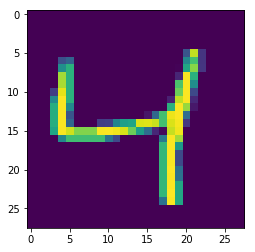

In [0]:
imshow(X_train_mnist[2].reshape(28, 28))

In [0]:
# normalize image vectors
X_train_cifar100 = X_train_cifar100 / 255.0
X_test_cifar100 = X_test_cifar100 / 255.0

# convert training and test labels to one hot encoded matrices
y_train_cifar100 = convert_to_one_hot(y_train_cifar100, 100).T
y_test_cifar100 = convert_to_one_hot(y_test_cifar100, 100).T

print("number of training examples = " + str(X_train_cifar100.shape[0]))
print("number of test examples = " + str(X_test_cifar100.shape[0]))
print("X_train shape: " + str(X_train_cifar100.shape))
print("y_train shape: " + str(y_train_cifar100.shape))
print("X_test shape: " + str(X_test_cifar100.shape))
print("y_test shape: " + str(y_test_cifar100.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 100)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 100)


In [0]:
model_cifar100.fit(X_train_cifar100, y_train_cifar100, epochs=20, batch_size=50)
predictions = model_cifar100.evaluate(X_test_cifar100, y_test_cifar100)

print("Loss: " + str(predictions[0]))
print("Test Accuracy " + str(predictions[1]))

KeyboardInterrupt: ignored

In [0]:
# normalize image vectors
X_train_mnist = X_train_mnist / 255.0
X_test_mnist = X_test_mnist / 255.0

# convert training and test labels to one hot encoded matrices
y_train_mnist = convert_to_one_hot(y_train_mnist, 10).T
y_test_mnist = convert_to_one_hot(y_test_mnist, 10).T

print ("number of training examples = " + str(X_train_mnist.shape[0]))
print ("number of test examples = " + str(X_test_mnist.shape[0]))
print ("X_train shape: " + str(X_train_mnist.shape))
print ("Y_train shape: " + str(y_train_mnist.shape))
print ("X_test shape: " + str(X_test_mnist.shape))
print ("Y_test shape: " + str(y_test_mnist.shape))

number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


In [0]:
model_mnist.fit(X_train_mnist, y_train_mnist, epochs=50, batch_size=250)
predictions = model_mnist.evaluate(X_test_mnist, y_test_mnist)

print("Loss: " + str(predictions[0]))
print("Test Accuracy: " + str(predictions[1]))

Epoch 1/50
60000/60000 [==============================] - 138s 2ms/sample - loss: 0.1795 - acc: 0.9459
Epoch 2/50
60000/60000 [==============================] - 138s 2ms/sample - loss: 0.0795 - acc: 0.9760
Epoch 3/50
60000/60000 [==============================] - 138s 2ms/sample - loss: 0.0454 - acc: 0.9859
Epoch 4/50
60000/60000 [==============================] - 138s 2ms/sample - loss: 0.0309 - acc: 0.9905
Epoch 5/50
60000/60000 [==============================] - 138s 2ms/sample - loss: 0.0209 - acc: 0.9930
Epoch 6/50
60000/60000 [==============================] - 138s 2ms/sample - loss: 0.0151 - acc: 0.9948
Epoch 7/50
60000/60000 [==============================] - 138s 2ms/sample - loss: 0.0111 - acc: 0.9963
Epoch 8/50
60000/60000 [==============================] - 138s 2ms/sample - loss: 0.0118 - acc: 0.9964
Epoch 9/50
60000/60000 [==============================] - 138s 2ms/sample - loss: 0.0089 - acc: 0.9969
Epoch 10/50
60000/60000 [==============================] - 138s 2ms/sampl

In [0]:
model_mnist.save("ResNetV2-164 MNIST.h5")

In [0]:
predictions


[0.06835103384113726, 0.9879]

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 28.0MB/s 


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
model_mnist.save('ResNetV2-164 MNIST.h5')
model_file = drive.CreateFile({'title' : 'ResNetV2-164 MNIST.h5'})
model_file.SetContentFile('ResNetV2-164 MNIST.h5')
model_file.Upload()

W0718 18:56:44.586663 139928867526528 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

In [0]:
# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1UJyR3IZt1xxdkSmp3yYvjgSrDZ-Xe2Op'})